# Team 1 - Final Project
## Israel Romero Olvera
#### In this project I'll create a predictive model that will take Midi files from 4 Master composers and classify them by artist name based solely on the musical structure.
### Section 1 - Functions and Class definition
#### This section includes all library imports as well as function definitions and the MidiDataset class implementation.

In [3]:
pip install pretty_midi

In [4]:
#Importing the required libraries
import os
import numpy as np
import random
import pandas as pd
from collections import defaultdict
import pretty_midi
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import BatchNormalization, Bidirectional, LSTM, LayerNormalization, Conv1D, MaxPooling1D, Dropout, LayerNormalization, LSTM, Bidirectional, Dense, Concatenate, Reshape, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
!git clone https://github.com/isralennon/MSAAI511

fatal: destination path 'MSAAI511' already exists and is not an empty directory.


In [6]:
#Preparing the directories to load the Midi files
!cd /content/drive/MyDrive/MSAAI511/FinalDataset
rootdir='./MSAAI511/FinalDataset'
#rootdir='./FinalDataset
#Preparing other variables that will be reused throughout this notebook
RANDOM_SEED = 75 #Define our random seed for reproducibility
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/bin/bash: line 1: cd: /content/drive/MyDrive/MSAAI511/FinalDataset: No such file or directory


In [7]:
path = rootdir
max_samples = 173
labels = []
label_to_idx = {}
samples = []
tmpCount = 0
#First, we load all the subfolders list, which represents the authors list
composer_dirs = [
    directory for directory in os.listdir(path)
    if os.path.isdir(os.path.join(path, directory))
]
print(composer_dirs)

['Mozart', 'Bach', 'Chopin', 'Beethoven']


### Model Function Definitions
#### The functions below will be used further along in the project. Defined here for logistic purposes.

In [8]:
def model_builder_cnn(n_classes, seq_len, max_notes, dropout=0.3):
    model = models.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(seq_len, max_notes, 2)),
        MaxPooling2D((2, 2)),
        LayerNormalization(),
        Dropout(dropout),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        #LayerNormalization(),
        #Dropout(dropout),
        #Conv2D(128, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])
    return model
def model_builder_lstm(n_classes, seq_len, max_notes, dropout=0.3):
    model = models.Sequential([
        layers.Input(shape=(seq_len, max_notes, 2)),  # (time, note tuple, pitch/velocity)
        layers.Reshape((seq_len, max_notes * 2)),  # Flatten pitch and velocity
        Bidirectional(layers.LSTM(128, return_sequences=True)),
        layers.Dropout(dropout),
        Bidirectional(layers.LSTM(64, return_sequences=False)),
        layers.Dropout(dropout),
        #Bidirectional(layers.LSTM(64, return_sequences=False)),
        #Fully connected head
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
    return model
def model_builder_combined(n_classes, seq_len, max_notes, dropout=0.3):
    n_notes=max_notes #Max number of notes in notes vector
    n_channels=2 #Number of Channels (pitch, velocity)

    input_layer = Input(shape=(seq_len, n_notes, n_channels))  # shape: (2400, 128, 2)
    # Reshape to (2400, 256) so Conv1D can be applied
    #reshaped_input = Reshape((self.seq_len, n_notes * n_channels))(input_layer)  # (2400, 256)

    # === CNN Branch ===
    x_cnn = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(input_layer)
    x_cnn = MaxPooling2D((2,2))(x_cnn)
    x_cnn = LayerNormalization()(x_cnn)
    x_cnn = Dropout(dropout)(x_cnn)

    #x_cnn = Conv1D(filters=128, kernel_size=3, dilation_rate=2, activation='relu', padding='same')(x_cnn)
    #x_cnn = MaxPooling1D(pool_size=3)(x_cnn)
    #x_cnn = LayerNormalization()(x_cnn)
    #x_cnn = Dropout(0.1)(x_cnn)

    x_cnn = layers.GlobalAveragePooling2D()(x_cnn)

    # === LSTM Branch ===
    # Reshape input to (seq_len, features)
    x_lstm = Reshape((seq_len, n_notes * n_channels))(input_layer)

    x_lstm = Bidirectional(LSTM(128, return_sequences=True))(x_lstm)
    x_lstm = Bidirectional(LSTM(128, return_sequences=False))(x_lstm)

    # === Combine Branches ===
    merged = Concatenate()([x_cnn, x_lstm])
    x = Dense(64, activation='relu')(merged)
    x = Dropout(dropout)(x)
    output = Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=output)
    return model

### MidiDataset Class
#### This class includes functions that handle data loading, data preprocessing, dataset generation, as well as plotting and reporting.

In [9]:
# Creating a class to handle the MIDI loading
class MidiDataset:
    def __init__(self, path, num_epochs=10, seq_len=300, fs=10, batch_size=16, allow_repeat=False, max_files=170, verbose=1):
        self.path = path #root folder with subfolders for each composer
        self.seq_len = seq_len #number of time steps per piano roll
        self.fs = fs #frames per second for piano roll
        self.train_samples = [] #placeholder for the training sample midi paths
        self.train_labels = [] #placeholder for the training labels
        self.author_labels_idx = {} #placeholder for the id labels for training
        self.test_samples = [] #placeholder for the testing sample midi paths
        self.test_labels = [] #placeholder for the testing labels
        self.val_samples = [] #placeholder for the validation sample midi paths
        self.val_labels = [] #placeholder for the validation labels
        self.num_epochs = num_epochs #Setting the number of epochs that our model will use
        self.max_samples = max_files #Due to class imbalance, I'm "downsampling" by limiting the number of midi files loaded per author
        self.batch_size = batch_size #Setting the batch size
        self.allow_repeat = allow_repeat #Setting to configure the dataset to allow repeating or not
        self.verbose = verbose
        self.breakpoint_note = 60 #This is the note used as threshold to separate melody from accompaniment. C4 = 60
        self.learning_rate = 0.0001 #Establishing the learning rate
        self._load_data()
    def _load_data(self):
        #First, we load all the files in the provided path into the labels and midi sample paths, as well as creating the catalog of author labels
        labels, self.author_labels_idx, samples = self.load_path(self.path)
        self.plot_authors_distribution(labels, 'All imported midi') #We plot the distribution of melodies per artist

        #Now, we'll load the contents of all midi files into their vectorized versions
        self.midi_vectors, self.max_notes = self.get_all_midi_vectors(samples)

        #Finally, we split the dataset in training, testing, and validation sets
        self.split_dataset(self.midi_vectors, labels)
    def load_path(self, path):
        labels = []
        label_to_idx = {}
        samples = []
        tmpCount = 0
        #First, we load all the subfolders list, which represents the authors list
        composer_dirs = [
            directory for directory in os.listdir(self.path)
            if os.path.isdir(os.path.join(self.path, directory))
        ]
        #Next, we load each individual midi file
        for idx, composer in enumerate(composer_dirs):
            label_to_idx[composer] = idx #Here we create a unique ID for each composer
            tmpCount = 0
            #Now, let's load all individual files in each composer's folder
            composer_path = os.path.join(path, composer)
            for fname in os.listdir(composer_path):
                if fname.endswith('.mid') or fname.endswith('.midi'): #Including any .MID or .MIDI files
                    file_path = os.path.join(composer_path, fname)
                    #if self.test_midi_file(file_path) == True: #If it's a valid Midi file, we add it. Otherwise, we skip it
                    if tmpCount < self.max_samples: #We're limiting the number of samples
                        samples.append(file_path)
                        labels.append(idx)
                    tmpCount=tmpCount+1
        return labels, label_to_idx, samples
    #This function will ensure a balanced split by author from the data, so the training set has a balanced number of samples
    def split_dataset(self, midi_vectors, labels):
        #First, we establish the vectors as arrays and store them temporarily into X and labels into y.
        X = np.array(midi_vectors)
        y = np.array(labels)

        #Step 1: Group indices by class label
        label_to_indices = defaultdict(list)
        for idx, label in enumerate(y):
            label_to_indices[label].append(idx)

        #Step 2: Determine minimum number of samples per class for equal training size
        min_class_count = min(len(indices) for indices in label_to_indices.values())
        train_count_per_class = int(0.8 * min_class_count)

        X_train_list, y_train_list = [], []
        X_test_list, y_test_list = [], []

        #Step 3: Split each class
        for label, indices in label_to_indices.items():
            np.random.shuffle(indices)  # Shuffle indices for randomness
            train_indices = indices[:train_count_per_class]
            test_indices = indices[train_count_per_class:]  # remainder goes to test

            X_train_list.append(X[train_indices])
            y_train_list.append(y[train_indices])

            X_test_list.append(X[test_indices])
            y_test_list.append(y[test_indices])

        #Step 4: Concatenate all parts into final arrays
        X_train = np.concatenate(X_train_list)
        y_train = np.concatenate(y_train_list)
        X_test = np.concatenate(X_test_list)
        y_test = np.concatenate(y_test_list)

        #Step 5: Shuffle the train and test sets independently
        train_perm = np.random.permutation(len(X_train))
        X_train, y_train = X_train[train_perm], y_train[train_perm]

        test_perm = np.random.permutation(len(X_test))
        X_test, y_test = X_test[test_perm], y_test[test_perm]

        #Saving the training set into class variables
        self.train_samples = X_train
        self.train_labels = y_train

        #Next, breaking the temp set in half so validation and testing sets end with 10% of the original set each.
        self.test_samples, self.val_samples, self.test_labels, self.val_labels = train_test_split(X_test, #Midi sample paths
                                                            y_test,                        #Author targets
                                                            test_size=0.5,            #50% of the data (10% for test, 10% for validation from original set)
                                                            random_state=RANDOM_SEED) #Set random seed
        print("Training set shape:", self.train_samples.shape)
        print("Test set shape:", self.test_samples.shape)
        print("Validation set shape:", self.val_samples.shape)
    ######################################################### MIDI FUNCTIONS ###########################################################
    #This function will convert all midi files into vectors and return them as a whole dataset
    def get_all_midi_vectors(self, sample_paths):
        midi_vectors=[] #Declaring the output vector
        max_tuples = 0 #Declaring the output max number of notes
        for path in sample_paths: #looping through all sample paths
            #Let's get the notes vector and max notes for each sample
            sample_vector, sample_max_notes = self.midi_to_vector(path)
            #Then, we append the sample vector to the output vector
            midi_vectors.append(sample_vector)
            #Next, we determine if the max number of this sample is the largest
            if sample_max_notes > max_tuples:
                max_tuples = sample_max_notes

        #Now, we'll proceed to pad all samples so they have the same number of notes
        padded_midi_vectors = []
        for i, sample in enumerate(midi_vectors):
            #sample shape: (2400, x, 2), where x is the variable number of simultaneous notes
            padded_sample = []

            for timestep in sample:  #iterate over 2400 timesteps (each timestep is x×2)
                x = timestep.shape[0]
                if x < max_tuples:
                    pad_width = max_tuples - x
                    padded_timestep = np.pad(
                        timestep,
                        pad_width=((0, pad_width), (0, 0)),  #pad only along x-axis
                        mode='constant',
                        constant_values=0.0
                    )
                elif x > max_tuples:
                    padded_timestep = timestep[:max_tuples, :]  # truncate to max_tuples
                else:
                    padded_timestep = timestep
                padded_sample.append(padded_timestep)

            # Convert to array (2400, 9, 2)
            padded_sample = np.stack(padded_sample)
            padded_midi_vectors.append(padded_sample)

        # Convert the whole thing to a 4D NumPy array: (500, 2400, 9, 2)
        padded_midi_array = np.stack(padded_midi_vectors)

        return padded_midi_array, max_tuples
    #This function will convert the midi notes into a piano roll
    def midi_to_pianoroll(self, midi_path):
         # Load MIDI
        midi_data = self.load_midi(midi_path)
        if midi_data is None:
            return None
        # Get first frame with a note
        first_active_frame = self.get_frame_first_note(midi_data)

        # Full piano roll, shape: (128, time)
        piano_roll = midi_data.get_piano_roll(fs=self.fs)
        piano_roll = piano_roll / 127.0  # Normalize velocity
        piano_roll = piano_roll[:, first_active_frame:]  # Trim leading silence
        piano_roll = piano_roll.T  # Now shape: (time, 128)

        # Pad or truncate to fixed length
        if piano_roll.shape[0] < self.seq_len:
            pad_width = self.seq_len - piano_roll.shape[0]
            piano_roll = np.pad(piano_roll, ((0, pad_width), (0, 0)))
        else:
            piano_roll = piano_roll[:self.seq_len]

        # Clip to valid MIDI range
        piano_roll = piano_roll[:, :128]

        return piano_roll
    def midi_to_vector(self, midi_path):
        piano_roll = self.midi_to_pianoroll(midi_path)
        #Getting the max number of simultaneous notes in this piano roll
        max_simultaneous_notes = self.get_piano_roll_max_simultaneous_notes(piano_roll)

        #Next, we'll obtain a notes vector from the piano roll, to capture positional note representation that can be used by the LSTM. Each tuple will contain a float representing the note, and another float with the velocity.
        notes_vector = self.get_notes_vector(piano_roll, max_simultaneous_notes)
        return notes_vector, max_simultaneous_notes
    def get_notes_vector(self, piano_roll, max_notes):
        output_vector = []
        printedvals = 0
        for step in piano_roll: #Looping through all timesteps of the piano roll
            temp_vector = []
            note_num = 0
            pos_num = 0
            for velocity in step: #Looping through each note in that timestep
                if velocity > 0: #if the velocity value is greater than 0 it means the note is on - so we add it to the vector.
                    note_array = [float(note_num) / 127, velocity]
                    temp_vector.append(note_array)
                    pos_num+=1
                note_num+=1
            #print(note_num)
            #After the available notes have been extracted, let's check if we need to pad so all vectors have the same shape
            if pos_num < max_notes:
                #if printedvals < 300:
                #    print(f'note_num: {note_num}, max_notes: {max_notes}')
                #printedvals += 1
                for i in range(pos_num, max_notes):
                    note_array = [0.0, 0.0]
                    temp_vector.append(note_array)
                    #print(temp_vector)
            #Next, we need to add the temp vector to the output vector
            output_vector.append(temp_vector)

        #Stacking the notes into a 3D array
        output_vector = np.stack(output_vector)
        #print(output_vector[0:1])
        return output_vector
    def get_piano_roll_max_simultaneous_notes(self, piano_roll):
        # Ensure tmpscore is not None
        if piano_roll is not None:
            max_simultaneous_notes = 0
            note_counts_per_timestep = []

            for timestep in piano_roll:
                # timestep shape: (128, 2) → notes × channels
                # Count all values > 0 across both melody and accompaniment
                num_active_notes = np.sum(timestep > 0)
                note_counts_per_timestep.append(num_active_notes)

                # Update maximum if current count is higher
                if num_active_notes > max_simultaneous_notes:
                    max_simultaneous_notes = num_active_notes

            return max_simultaneous_notes
        else:
            return 0
    def load_midi(self, midi_path):
        try:
            return pretty_midi.PrettyMIDI(midi_path)
        except Exception as e:
            print(f"⚠️ Skipping {midi_path}: {e}")
            return None
    def get_frame_first_note(self, midi_content):
        #Get all note start times
        note_start_times = [note.start for instrument in midi_content.instruments for note in instrument.notes]
        #Get the first note time
        first_note_time = min(note_start_times)
        #Calculate the frame in which the note shows up
        first_frame = int(first_note_time * self.fs)
        #Return the first frame
        return first_frame
    def generator(self, samples, labels):
        #This function generates a midi piano roll, calculates the max number of simultaneous notes, and gets the notes vector for the specified file
        for notes_vector, label in zip(samples, labels):
        #    notes_vector, max_notes = self.midi_to_pianoroll(midi_path)
            yield notes_vector, label
    #This function builds the TensorFlow dataset
    def get_tf_dataset(self, samples, labels, batch_size=16, shuffle=True):
        output_signature = (
            tf.TensorSpec(shape=(self.seq_len, self.max_notes, 2), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
        dataset = tf.data.Dataset.from_generator(
            lambda: self.generator(samples, labels),
            output_signature=output_signature
        )
        #The shuffle parameter will help the Neural Network training by shuffling the sample's order, preventing the model from seeing samples in the same order every epoch
        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(samples))
            #dataset = dataset.repeat() #Preparing the dataset to be repeated indefinitely during epochs
            #dataset = dataset.shuffle(buffer_size=len(self.train_samples))
        dataset = dataset.batch(batch_size) #Preparing the dataset in the specified batches
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset
    def test_midi_file(self, file):
        tmpOpen = self.load_midi(file)
        if tmpOpen == None:
            return False
        return True
    #################################################### MODEL FUNCTIONS #######################################################
    def build_model(self, architecture='CNN', learning_rate=0.0001): #Architectures are CNN, LSTM, and Combined
        self.learning_rate = learning_rate
        self.architecture = architecture
        if architecture == 'CNN':
            model = model_builder_cnn(len(self.author_labels_idx), self.seq_len, self.max_notes)
        elif architecture == 'LSTM':
            model = model_builder_lstm(len(self.author_labels_idx), self.seq_len, self.max_notes)
        elif architecture == 'Combined':
            model = model_builder_combined(len(self.author_labels_idx), self.seq_len, self.max_notes)
        self.model = model
        #In this method, the class will compile the model and train it using the training set, returning the evaluation metrics.
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), metrics=['accuracy'])
        #Next, print the model summary
        self.model.summary()
    def train(self, batch_size=None):
        #Updating batch size when needed
        if not batch_size == None:
            self.batch_size = batch_size

        #Preparing the Early Stopping if needed
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        #Now, calculating the history after fitting the model with the training set
        history = self.model.fit(
            self.train_samples,
            self.train_labels,
            validation_data=(self.val_samples, self.val_labels),
            batch_size=self.batch_size,
            epochs=self.num_epochs,
            callbacks=[early_stopping],
            verbose=self.verbose
        )
        #Plotting the epochs history
        self.plot_epochs_history(history)
        return self.evaluate(self.train_samples, self.train_labels, 'Training Dataset')

    def predict(self, dataset):
        #This method allows the model to predict the target outputs for the input X
        predictions = self.model.predict(dataset) #We execute and store the predictions
        predicted_labels = np.argmax(predictions, axis=1)
        return predicted_labels
    def test(self):
        #This method evaluates the predictions built with the testing set
        return self.evaluate(self.test_samples, self.test_labels, 'Testing Dataset')
    def validate(self):
        return self.evaluate(self.val_samples, self.val_labels, 'Validation Dataset')
    def evaluate(self, dataset, labels, title=''):
        #This method evaluates the performance of the ANN with the selected parameters
        pred_labels = self.predict(dataset) #First, we perform the predictions
        true_labels = labels
        #Next, we'll get the true labels directly from the dataset, which contains the tensor-label pair
        #for _, label_batch in dataset:
        #    true_labels.extend(label_batch.numpy())
        #true_labels = np.array(true_labels)
        #If we specify a title value means we also want to print a confusion matrix chart.
        if not title == '':
            self.print_confusion_matrix(true_labels, pred_labels, title)
        #Then, we used the actual values and predicted values to calculate all metrics
        accuracy = accuracy_score(true_labels, pred_labels)
        precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
        recall = recall_score(true_labels, pred_labels, average='weighted')
        f1 = f1_score(true_labels, pred_labels, average='weighted')
        #Finally, we return the metrics
        return np.round((accuracy, precision, recall, f1), decimals=2)
    def get_num_samples(self, dataset):
        sample_count = sum(1 for _ in dataset)
        return sample_count
    #################################################### PLOTTING AND MISC FUNCTIONS #####################################################
    #Creating this function to visually represent a piano roll of a sample
    def plot_piano_roll(self, midi_path, title="Piano Roll", save_path=None):
        #First we obtain the piano roll based on the path
        piano_roll = midi_to_pianoroll(midi_path)
        time_steps = piano_roll.shape[0] #Getting timesteps
        duration = time_steps / self.fs #Calculating duration
        time_axis = np.linspace(0, duration, time_steps) #Preparing time axis dimension
        print(f'Time Steps: {time_steps}, Frames per Second: {self.fs}, Duration: {duration:.2f}s')

        plt.figure(figsize=(12, 6))
        plt.imshow(piano_roll.T, aspect='auto', origin='lower',
                   extent=[0, duration, 0, piano_roll.shape[1]], cmap='gray_r')
        plt.xlabel('Time (s)')
        plt.ylabel('MIDI Note')
        plt.title(title)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
        else:
            plt.show()
    def plot_epochs_history(self, history):
        #Defining a plotting size
        if self.architecture == 'Combined':
            title = '(Combined CNN + LSTM)'
        else:
            title = f'({self.architecture})'
        plt.figure(figsize=(12, 6))
        #Preparing the Accuracy per Epoch plot
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
        plt.title(f'Model Accuracy Tracking per Epoch {title}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.legend()
        #Preparing the Model Loss per Epoch plot
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss', marker='o')
        plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
        plt.title(f'Model Loss Tracking per Epoch {title}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()
        #Finalizing the layout settings
        plt.tight_layout()
        plt.show()
    def plot_authors_distribution(self, train_labels, title):
        #Convert labels to a DataFrame
        df = pd.DataFrame(train_labels, columns=['Author'])

        #Count each author label
        counts = df['Author'].value_counts().sort_index()

        #Mapping the numeric labels to the author names
        author_names = self.author_labels_idx.keys()

        #Ploting
        plt.figure(figsize=(10, 5))
        plt.bar(author_names, counts.values)

        #Label formatting
        plt.xticks(rotation=0)
        plt.ylabel('Frequency')
        plt.xlabel('Authors')
        plt.title(f'Author sample counts - {title}')
        plt.tight_layout()
        plt.show()
    def print_num_samples(self):
        print(f'Training samples: {self.num_samples_train}, Testing samples: {self.num_samples_test}, Val samples: {self.num_samples_val}.')
    def print_confusion_matrix(self, true_labels, predicted_labels, title):
        if self.architecture == 'Combined':
            architecture = f'(Combined CNN + LSTM) - {title}'
        else:
            architecture = f'({self.architecture}) - {title}'
        print(f'\nClassification Report {architecture}:')
        print(classification_report(true_labels, predicted_labels, target_names=self.author_labels_idx.keys()))
        cm = confusion_matrix(true_labels, predicted_labels)
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=self.author_labels_idx.keys(), yticklabels=self.author_labels_idx.keys())
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix {architecture}')
        plt.show()

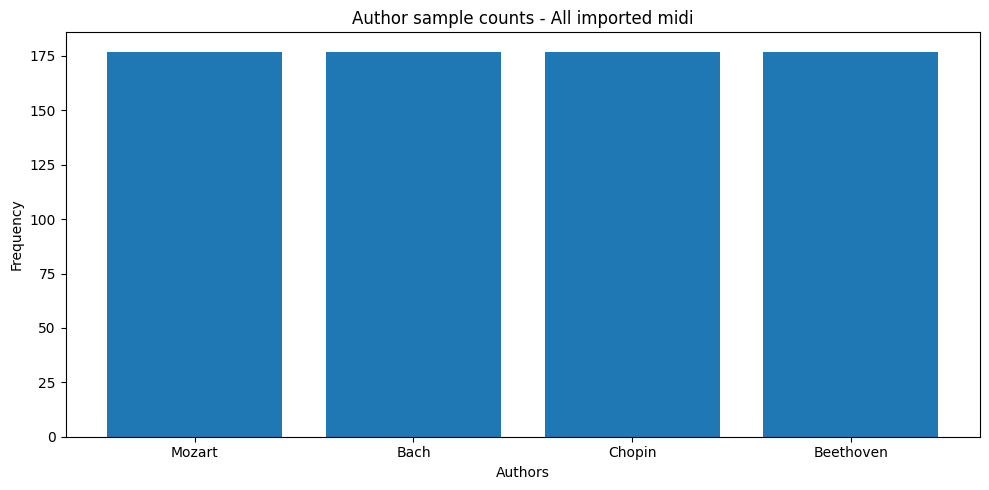

/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [ ]:
#For the model, I'll use 15 epochs, a frequency of 64 frames per second, and a duration of 60 seconds, which at 64 fps would be 3840 frames
midi_model = MidiDataset(path=rootdir, num_epochs=15, seq_len=3840, fs=64, batch_size=32, allow_repeat=False, max_files=177, verbose=0)

### CNN Experiment
#### First, let's try running the CNN model.

In [1]:
#First, we'll experiment with CNN model alone
midi_model.build_model(architecture='CNN')
#Testing with CNN
training_accuracy, training_precision, training_recall, training_f1 = midi_model.train()

NameError: name 'midi_model' is not defined

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 525ms/step

Classification Report (CNN) - Testing Dataset:
              precision    recall  f1-score   support

        Bach       0.77      1.00      0.87        20
   Beethoven       0.58      0.55      0.56        20
      Chopin       0.53      0.60      0.56        15
      Mozart       0.70      0.41      0.52        17

    accuracy                           0.65        72
   macro avg       0.64      0.64      0.63        72
weighted avg       0.65      0.65      0.64        72



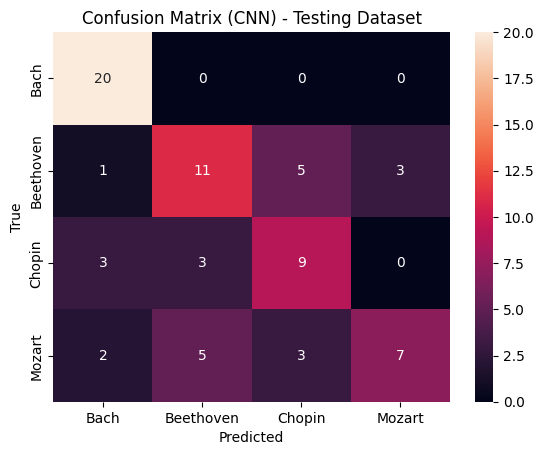

In [ ]:
#Verifyint the Testing accuracy with the CNN model alone
testing_accuracy, testing_precision, testing_recall, testing_f1 = midi_model.test()

### LSTM Experiment
#### Now, let's try running the LSTM model.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 3840, 86)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 3840, 256)      │       220,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3840, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 393,028 (1.50 MB)

 Trainable params: 393,028 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

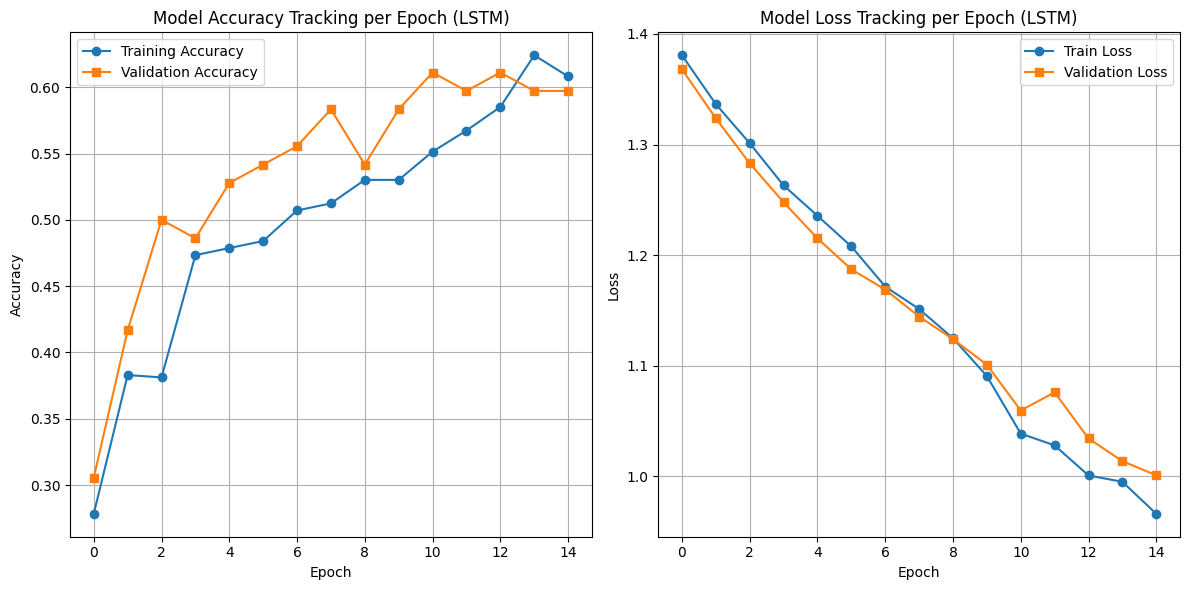

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step

Classification Report (LSTM) - Training Dataset:
              precision    recall  f1-score   support

      Mozart       0.59      0.57      0.58       141
        Bach       0.75      0.72      0.73       141
      Chopin       0.54      0.68      0.60       141
   Beethoven       0.64      0.52      0.58       141

    accuracy                           0.62       564
   macro avg       0.63      0.62      0.62       564
weighted avg       0.63      0.62      0.62       564



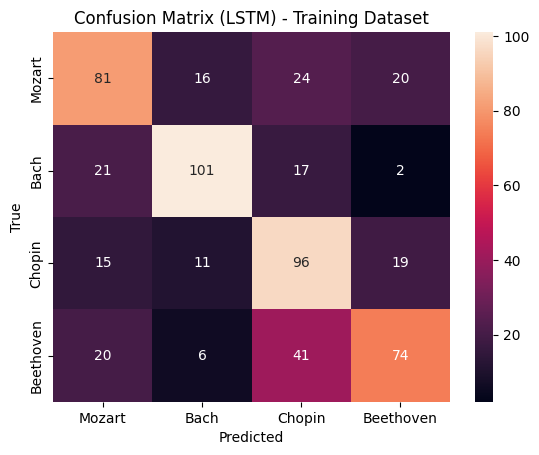

In [23]:
#First, we'll experiment with LSTM model alone
midi_model.build_model(architecture='LSTM', learning_rate=0.0001)
#Testing with LSTM
training_accuracy, training_precision, training_recall, training_f1 = midi_model.train()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step

Classification Report (LSTM) - Testing Dataset:
              precision    recall  f1-score   support

      Mozart       0.52      0.55      0.54        20
        Bach       0.75      0.60      0.67        20
      Chopin       0.38      0.60      0.46        15
   Beethoven       0.45      0.29      0.36        17

    accuracy                           0.51        72
   macro avg       0.53      0.51      0.51        72
weighted avg       0.54      0.51      0.51        72



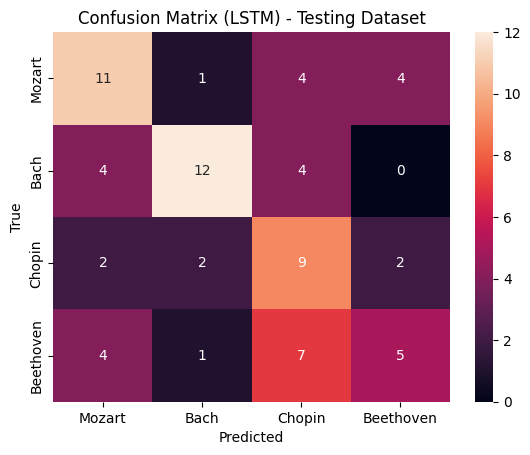

In [24]:
testing_accuracy, testing_precision, testing_recall, testing_f1 = midi_model.test()

### Combined Experiment
#### Finally, let's try running a combined CNN + LSTM model, both running in parallel, and combining their outputs for prediction.

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 3840, 43,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 3838, 41,  │        608 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 1919, 20,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1919, 20,  │         64 │ max_pooling2d_3[… │
│ (LayerNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 3840, 86)  │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 1919, 20,  │          0 │ layer_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 3840, 256) │    220,160 │ reshape_3[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ dropout_7[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 256)       │    394,240 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 288)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │     18,496 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 4)         │        260 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 633,828 (2.42 MB)

 Trainable params: 633,828 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

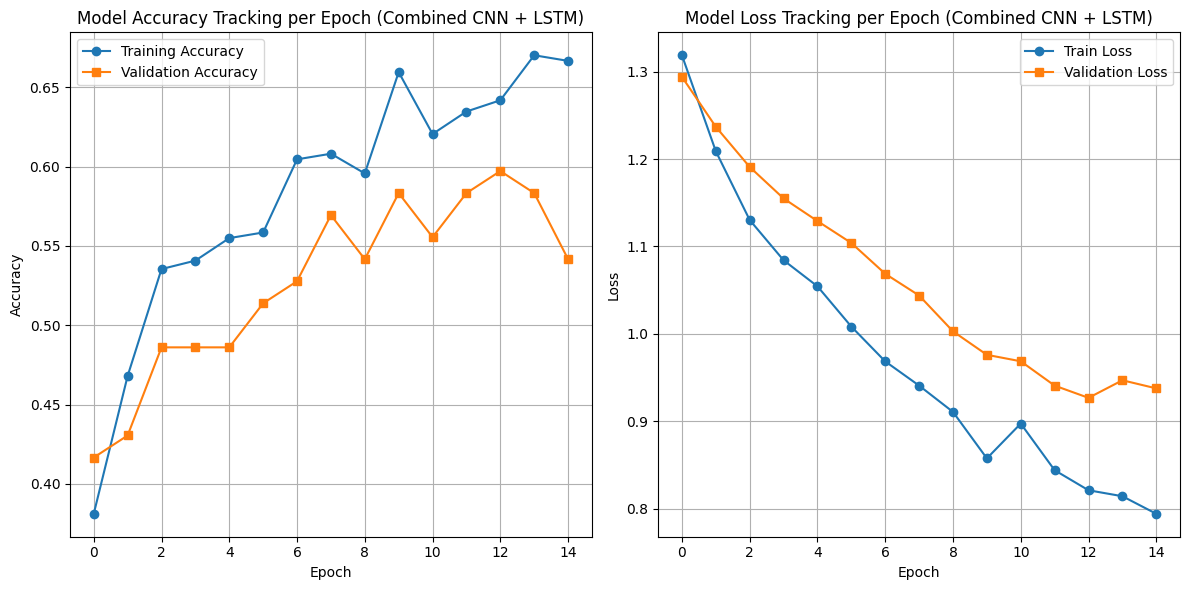

18/18 ━━━━━━━━━━━━━━━━━━━━ 112s 6s/step 

Classification Report (Combined CNN + LSTM) - Training Dataset:
              precision    recall  f1-score   support

        Bach       0.90      0.93      0.91       141
   Beethoven       0.68      0.56      0.61       141
      Chopin       0.62      0.64      0.63       141
      Mozart       0.55      0.62      0.58       141

    accuracy                           0.69       564
   macro avg       0.69      0.69      0.69       564
weighted avg       0.69      0.69      0.69       564



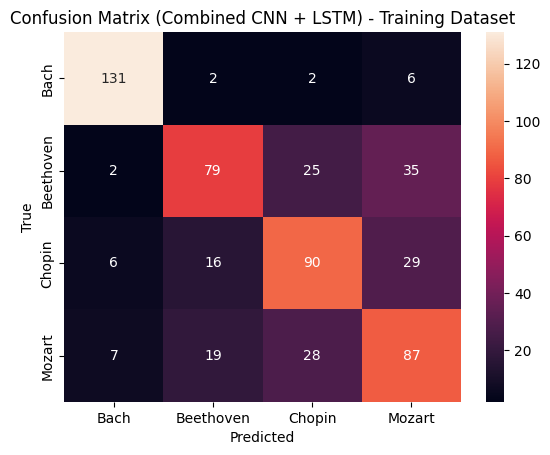

In [ ]:
#Next, we'll experiment with Combined model
midi_model.build_model(architecture='Combined')
#Testing with CNN + LSTM
training_accuracy, training_precision, training_recall, training_f1 = midi_model.train()

### Other Performance Experiments
#### I'll aim to modify the hyperparameters to attempt on improving the performance of the CNN and LSTM models

C:\Users\isral\.conda\envs\IRO\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 3838, 41, 32)   │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1919, 20, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 1919, 20, 32)   │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1919, 20, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1917, 18, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 958, 9, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 551808)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │    35,315,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,335,204 (134.79 MB)

 Trainable params: 35,335,204 (134.79 MB)

 Non-trainable params: 0 (0.00 B)

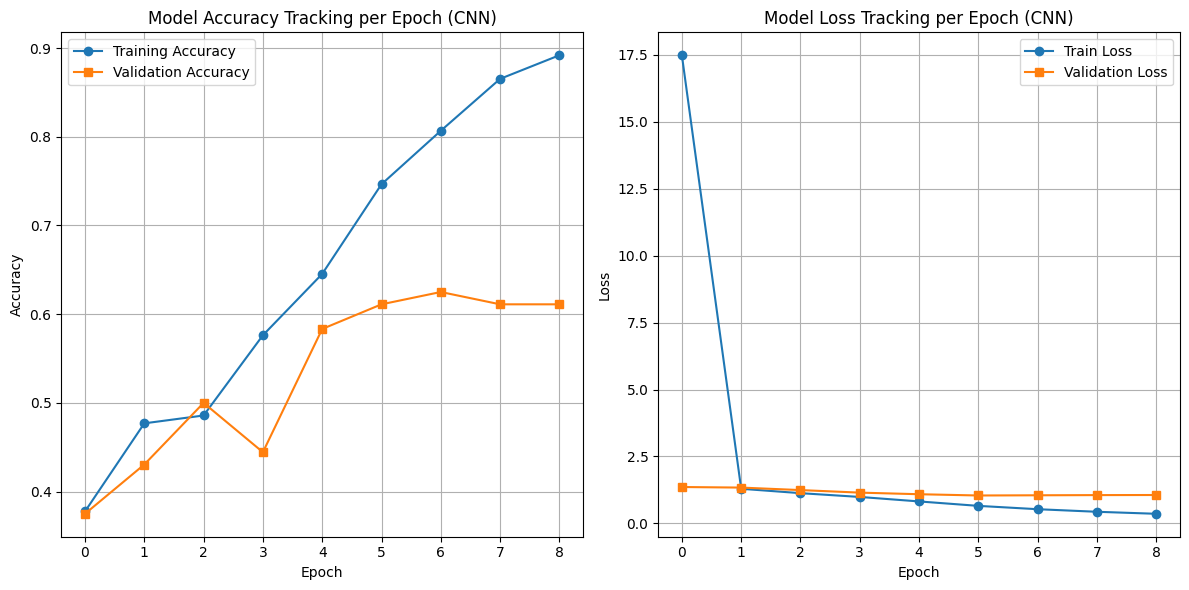

18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 656ms/step

Classification Report (CNN) - Training Dataset:
              precision    recall  f1-score   support

        Bach       0.78      0.99      0.87       141
   Beethoven       0.91      0.48      0.62       141
      Chopin       0.92      0.91      0.91       141
      Mozart       0.67      0.82      0.74       141

    accuracy                           0.80       564
   macro avg       0.82      0.80      0.79       564
weighted avg       0.82      0.80      0.79       564



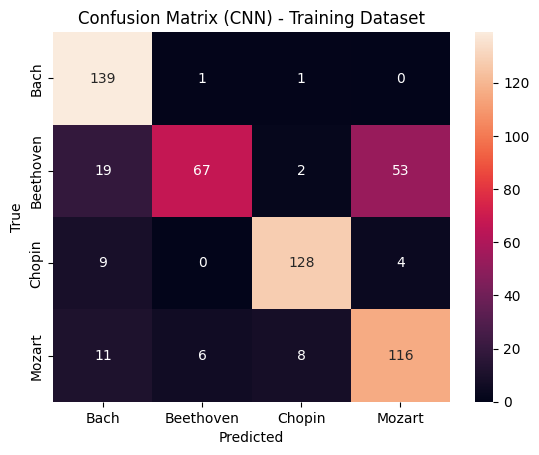

In [ ]:
#First, we'll experiment with CNN model alone with a learning rate of 0.001 instead of 0.0001
midi_model.build_model(architecture='CNN', learning_rate=0.001)
#Testing with CNN also updating the batch size to 64
training_accuracy, training_precision, training_recall, training_f1 = midi_model.train(batch_size=64)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step

Classification Report (CNN) - Testing Dataset:
              precision    recall  f1-score   support

        Bach       0.80      1.00      0.89        20
   Beethoven       0.67      0.10      0.17        20
      Chopin       0.58      0.73      0.65        15
      Mozart       0.48      0.71      0.57        17

    accuracy                           0.62        72
   macro avg       0.63      0.63      0.57        72
weighted avg       0.64      0.62      0.56        72



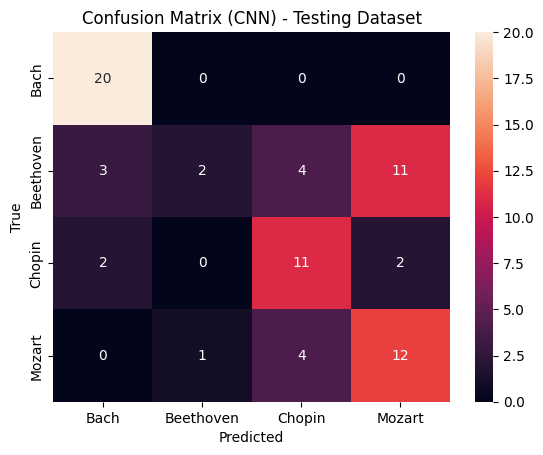

In [ ]:
testing_accuracy, testing_precision, testing_recall, testing_f1 = midi_model.test()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 3840, 86)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 3840, 256)      │       220,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3840, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 393,028 (1.50 MB)

 Trainable params: 393,028 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

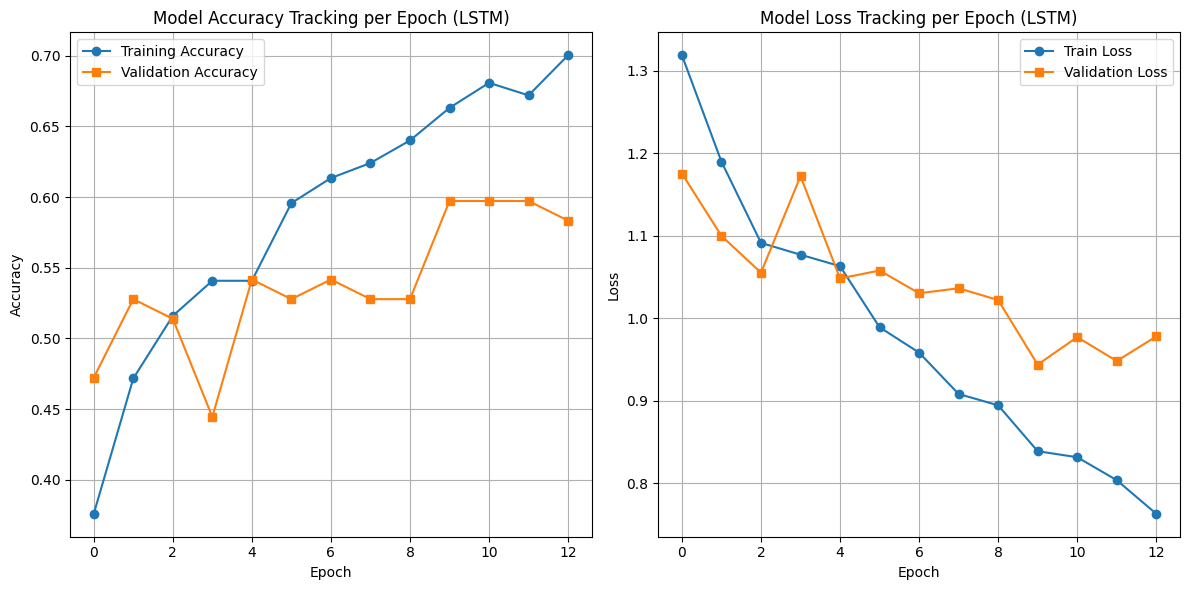

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step

Classification Report (LSTM) - Training Dataset:
              precision    recall  f1-score   support

      Mozart       0.64      0.58      0.61       141
        Bach       0.74      0.78      0.76       141
      Chopin       0.65      0.81      0.72       141
   Beethoven       0.74      0.58      0.65       141

    accuracy                           0.69       564
   macro avg       0.69      0.69      0.68       564
weighted avg       0.69      0.69      0.68       564



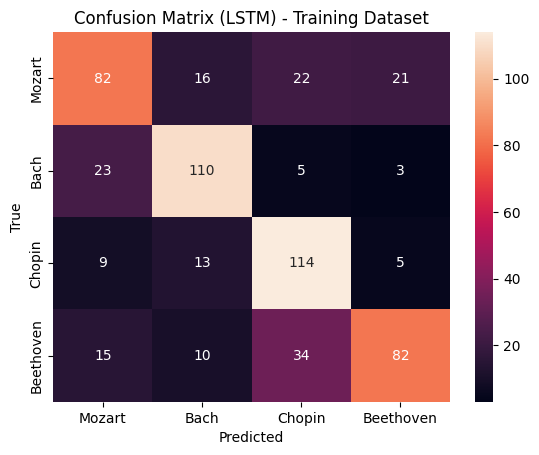

In [25]:
#First, we'll experiment with LSTM model alone with a learning rate of 0.001 instead of 0.0001
midi_model.build_model(architecture='LSTM', learning_rate=0.001)
#Testing with LSTM also updating the batch size to 64
training_accuracy, training_precision, training_recall, training_f1 = midi_model.train(batch_size=64)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step

Classification Report (LSTM) - Testing Dataset:
              precision    recall  f1-score   support

      Mozart       0.40      0.40      0.40        20
        Bach       0.76      0.65      0.70        20
      Chopin       0.44      0.73      0.55        15
   Beethoven       0.50      0.29      0.37        17

    accuracy                           0.51        72
   macro avg       0.53      0.52      0.51        72
weighted avg       0.53      0.51      0.51        72



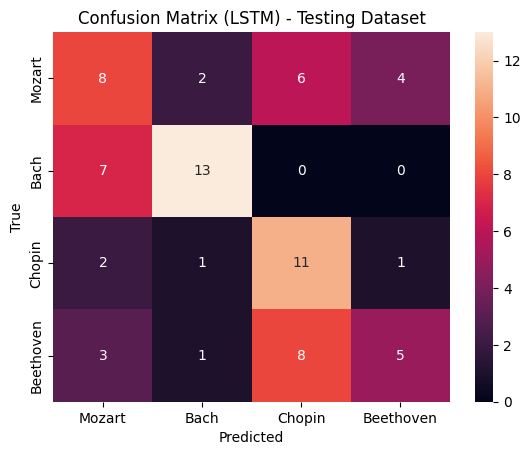

In [26]:
testing_accuracy, testing_precision, testing_recall, testing_f1 = midi_model.test()

#### Conclusions are described in the Final Report.

In [26]:
!cd /

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num Logical GPUs Available: ", len(tf.config.list_logical_devices('GPU')))
print("Physical devices:", tf.config.list_physical_devices())